# Project on :- Classification of musical instrument using Convolutional Neural Network (CNN)

### Below is the list of what we need to do:

1. Data collection
2. Data generation
3. Features preprocessing (using MFCC)
4. Label preprocessing
5. Model training (using CNN)
6. Model evaluation

# Step 1: Data collection


- As always, the first thing I do when working with machine learning or deep learning projects is collecting all required data. I am taking thousands of audio files from a Kaggle competition which you can download from this link: https://www.kaggle.com/c/freesound-audio-tagging/data. The dataset contains 41 classes in which each of those represents the name of a musical instrument such as cello, chime and clarinet. Actually there are also some other non-musical instrument sounds like telephone and fireworks in the dataset. However, here in my project I decided to choose only 5 musical instruments to be classified for simplicity.

In [1]:
# Import the various Libraries
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


- librosa is a Python module which I use to load all audio data.
- mfcc is a function coming with python_speech_features module which is very important to extract audio features to make those audio wave data more informative.
- tqdm is use to display progress bar in a loop operation.

In [2]:
# Import the data
df = pd.read_csv('train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


- Data set contains three columns fname is audio file, label indicates the name of instrument and manually_verified is real person verified about the label name indicate along with row is correct or not.
1- correct as label,
0 - incorrect as label

In [3]:
df.label.nunique()

41

- 41 type of instruments aviable in data set 

In [4]:
# Take 5 classes from the dataset
df = df[df['label'].isin(['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'])]


- Out of 41 instrument we take only these five instruments.

In [5]:
# Loading data
path = 'audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 1500/1500 [10:55<00:00,  2.29it/s]
C:\Users\rajan\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


- Here I declared an empty list called audio_data and append each of raw audio data using librosa.load() function. 
- Shape of this audio_data variable is (1500, 2).
- Lastly, I also convert the audio_data list into Numpy array.

In [6]:
# Put the loaded data into data frame
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,manually_verified,audio_waves,samplerate
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050


- Now we will put the content of audio_data variable into data frame df

In [7]:
# Calculate the length of each audio file
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['second_lengths'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,second_lengths
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050,154350,7
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050,125685,5.7


- bit_lengths is essentially just the number of bits in each audio waves.
- second_lengths is the length of all audio files in seconds.
- In order to get the value for second_lengths, we can simply divide the number of all bits of each audio wave with the corresponding sample rate.

# Step 2: Data generation

Up to this point, we already got a data frame df which now contains the length of all audio files. We just realized that actually all those audios are having different lengths. And well, this is a problem. Why? Because any machine learning or deep learning classifier models only accept data with exact same shape for each sample. So now, the solution is to make those data having the same length. In this project, I decided to go with 2 seconds of audio data.
In order to do it, the first thing I wanna do is to drop all samples which are shorter than 2 seconds.

In [8]:
# Take only the audio with >= 2 seconds audio length
df = df[df['second_lengths'] >= 2.0]

In [9]:
# In case you want to create a checkpoint
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [10]:
# In case you want to load a checkpoint
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [11]:
# Check whether our minimum length is 2 seconds or more
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['second_lengths'])
print(min_seconds)

44100
2.0


In [12]:
# Generate 60000 data
num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:15<00:00, 378.70it/s]


- Well, the point of the code above is to generate 2-seconds length audio in which it is stored in generated_audio_waves (for the wave data itself) and generated_audio_labels (for the labels of the corresponding wave data). Here I decided to take 6000 audio chunks which I declared using num_samples variable. Next, after generating all data, I also convert both lists to Numpy array because I think it’s just simpler than Python list.

# Step 3: Features preprocessing

- Raw audio wave that we extracted in step 1 using librosa is not really informative since it essentially only consists of one-dimensional data stored in an array. This array shape only represents the amplitude (loudness) of each bit. In fact, loudness is not the only feature that we want to take into account when we are about to distinguish different sounds. Instead, it is also necessary to consider the pitch of those audios. Therefore, in order to extract the pitch information based on given raw audio we are going to utilize a function called mfcc().

In [13]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5970/5970 [00:51<00:00, 117.04it/s]


-  Since it contains all the raw audio data, then we can simply use a for loop to iterate through all the values of the array and convert each of the waves into MFCC features.

In [14]:
# Check the shape of raw wave and MFCC features
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5970, 44100)
(5970, 275, 13)


- Now the shape of mfcc_features represents the number of audio data and the heatmap image with the size of 275 times 13 produced using mfcc() function.

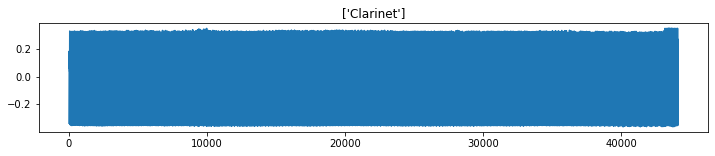

In [15]:
#Print a raw audio wave
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()

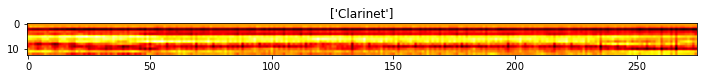

In [16]:
# Print the MFCC features of the audio wave
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

# Step 4: Label preprocessing

- Remember that the values in our generated_audio_labels array are still in form of raw categorical data (i.e. cello, saxophone, acoustic guitar, double bass and clarinet), which is absolutely not acceptable by neural network. Therefore, my approach here is to utilize LabelEncoder() and OneHotEncoder() object coming from Sklearn module.

In [17]:
# Label encoding
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

label_encoded = label_encoded[:, np.newaxis]
print(label_encoded)

[2 3 4 ... 1 4 0]
[[2]
 [3]
 [4]
 ...
 [1]
 [4]
 [0]]


C:\Users\rajan\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [18]:
# One hot encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
print(one_hot_encoded)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


# Step 5: Model training

- Before training the model, I convert mfcc_features and one_hot_encoded into X and y respectively to make things look more intuitive. Next, I also normalize the values of all samples using standard normalization formula. Lastly, the data are split into train and test in which the test size is taken from 20% of the entire dataset. This train-test split is important to find out whether our model suffers overfitting.

In [19]:

X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())

In [20]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
# Defining input shape for the neural network
input_shape = (X_train.shape[1], X_train.shape[2], 1)


- If you try to print out that input_shape, the result will be (275, 13, 1). Notice that the number 1 in the shape (last shape axis) should be there because it is just what is expected by Conv2D() layer in our neural network. Hence, we also need to reshape both X_train and X_test to be in that shape as well.

In [22]:
# Reshape X_train and X_test such that they are having the same shape as the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4776, 275, 13, 1)
(1194, 275, 13, 1)


In [23]:
# Constructing the neural network architecture
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

- Now it’s time to actually build the Convolutional Neural Network (CNN) classifier. The reason why I use CNN is because this architecture is usually considered as one of the best to solve image classification task and in our case here, the images are in form of heatmap like what I displayed earlier. The complete architecture implementation is shown above along with the loss function and optimizer.

- It might be important to keep in mind that categorical cross entropy loss function is used in this case because we are dealing with multiclass classification. Whereas, Adam optimizer is also chosen because I think it is just the best one right now.


In [31]:
 model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 275, 13, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 275, 13, 32)       4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 137, 6, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 137, 6, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26304)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3367040   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [24]:
# Training the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Train on 4776 samples, validate on 1194 samples
Epoch 1/30
4776/4776 [==============================] - 33s 7ms/step - loss: 1.5076 - acc: 0.3061 - val_loss: 1.2258 - val_acc: 0.4732
Epoch 2/30
4776/4776 [==============================] - 12s 3ms/step - loss: 1.2576 - acc: 0.4322 - val_loss: 1.1299 - val_acc: 0.5469
Epoch 3/30
4776/4776 [==============================] - 12s 3ms/step - loss: 1.1283 - acc: 0.5291 - val_loss: 0.9526 - val_acc: 0.6441
Epoch 4/30
4776/4776 [==============================] - 12s 3ms/step - loss: 1.0402 - acc: 0.5938 - val_loss: 0.9392 - val_acc: 0.6449
Epoch 5/30
4776/4776 [==============================] - 12s 3ms/step - loss: 0.9740 - acc: 0.6219 - val_loss: 0.8452 - val_acc: 0.6926
Epoch 6/30
4776/4776 [==============================] - 12s 3ms/step - loss: 0.9039 - acc: 0.6604 - val_loss: 0.7738 - val_acc: 0.7035
Epoch 7/30
4776/4776 [==============================] - 12s 3ms/step - loss: 0.8492 - acc: 0.6840 - val_loss: 0.7503 - val_acc: 0.7102
Epoch 8

- After compiling the model, now our CNN is ready to train. Here I decided to go with 30 epochs, which hopefully will be enough to obtain high accuracy. I ran the code above to start training the model. Also, note that I put the entire training process into history variable which will be useful to track the progress.

loss: 0.36750231031796443
val_loss: 0.47696179076654827


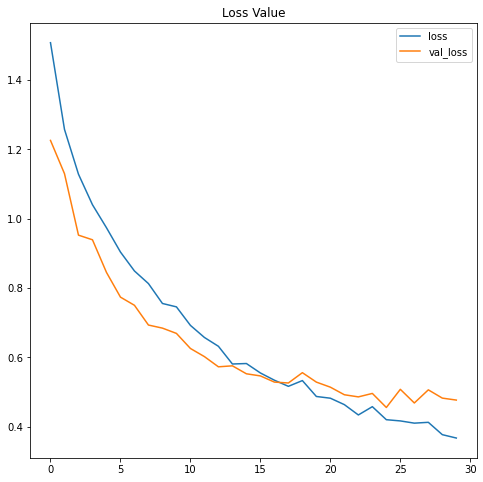

In [25]:
# Displaying loss values
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

acc: 0.8641122
val_acc: 0.8475711941719055


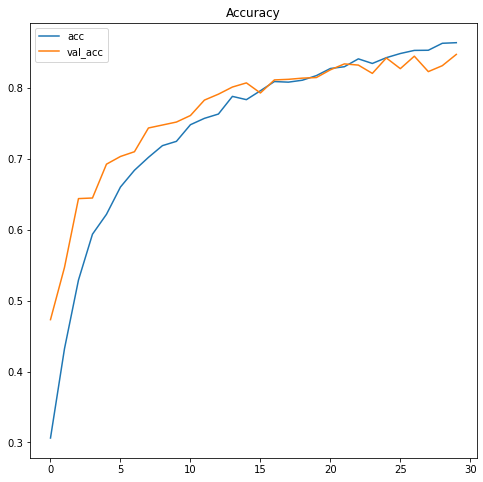

In [26]:
# Displaying accuracy scores
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

- According to the two graphs above, we can see that our model is performing pretty well as it reaches the final accuracy of 84% and 86% towards train and test data respectively. Also, both loss values are also decreasing as the the number of epoch increases. Therefore, we can conclude that this CNN classifier does not suffer overfitting at all!

# Step 6: Model evaluation

- Now let’s get deeper into the CNN model. In order to evaluate the performance of the model better, we are going to predict both train and test data again, but in a different session with the training process

In [27]:
# predicting the test data
predictions = model.predict(X_test)

In [28]:
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

- The code above shows how to take the argmax of all predictions on X_test and then followed by decoding y_test into the same form as the predictions variable (because previously we already converted y_test into one-hot representation, now we need to convert that back to label-encoded form). This is extremely necessary to do because we want to compare each of the element of predictions and y_test.

- As predictions and y_test are now comparable, we can start to create a confusion matrix to evaluate the model performance better. Here we are going to use confusion_matrix function taken from Sklearn module.

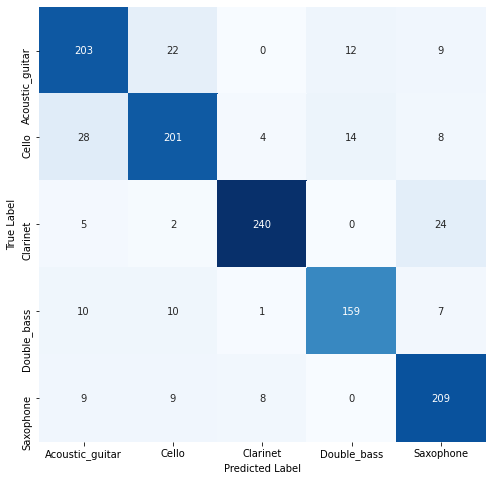

In [29]:
# Creating confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

- Using the confusion matrix above, we are able to know which class makes our CNN confused. Let’s take a look at saxophone true label (last row). Here we can see that 209 samples are predicted correctly, while 8 other saxophone samples are predicted as clarinet. Hence, we can guess that probably our classifier sometimes get difficulty to distinguish the sound of saxophone and clarinet.

# Thank You!